In [1]:
import numpy as np
import pandas as pd
import random as rand_
import matplotlib.pyplot as plt

from math import pi, cos, sin, exp, floor, atan
from cmath import sqrt
from scipy.signal import StateSpace, impulse2, lsim2
from scipy.optimize import least_squares
from scipy.linalg import lstsq
from jupyterthemes import jtplot

jtplot.style()

In [2]:
class MOLIwhiteBox:
    def __init__(self, method):
        self.C = np.array([[0., 0., 0., 1.]])
        if method is None:
            method = 'trivial'
        self.filter = method
        self.structure() #defines the model structure
        self.describe() #print a model definition
        
    def structure(self):
        if self.filter == 'trivial':
            zeta = 0.
            omega = pi/12.0
            _p1 = -zeta*omega + omega*sqrt(zeta**2-1)
            _p2 = -zeta*omega - omega*sqrt(zeta**2-1)
            syscpoly = np.poly((-1.0*0.0353,_p1,_p2))
            sysc = np.concatenate((np.zeros([1]),np.flip(-syscpoly[1:])),0)
            
            A_ = np.concatenate((np.zeros([1,3]),np.identity(3)),0)
            A_ = np.concatenate((A_,sysc.reshape([4,1])),1)
            
            alphacand = np.poly(np.linalg.eig(A_)[0])
            A0 = np.concatenate((np.zeros([1,3]),np.identity(3)),0)
            A0 = np.concatenate((A0,-np.flip(alphacand[1:]).reshape([4,1])),1)
            self.A = A0
            
    def describe(self):
        print('This is a MOLI white Box alertness model')
        
    def fit(self, timeSamp, y, windowDecision):   
        self.awakeRegression(timeSamp, y) #determine the parameters during the day
        self.parameters(timeSamp) #determine the bio/physical parameters
        self.sim_Back_Forward(timeSamp, y, windowDecision) #determine the homeostatic vicinities
        self.sleepRegression()
        
    def awakeRegression(self, timeSamp, y):
        A_, C_, I_ = np.transpose(self.A), np.transpose(self.C), np.identity(4) 
        sFilt = StateSpace(A_,C_,I_,np.zeros([4,1]))
        _B, regres, _y = np.zeros([4,y.size]), np.array([]), []
    
        for i in range(y.size):
            sigAl, _time = np.asarray(y[i]), np.asarray(timeSamp[i])
            
            time_sim = _time - _time[0] #initialize time at t[0] = 0 (hours)
            impT, impResp = impulse2(sFilt, 0, time_sim, N = 10000) #simulate B info
            outT, outResp, x2 = lsim2(sFilt, sigAl, time_sim) #simulate L info
            
            comp = np.zeros([impT.size,4*y.size])
            comp[:,4*i:4*(i+1)] = impResp
            aux = np.concatenate((outResp,comp),1)
            
            if i == 0: #initialize the regressor, or add info to the regressor
                regres = aux
                _y = np.asarray(y[i])
            else:
                regres = np.concatenate((regres,aux), 0)
                _y = np.concatenate((_y,np.asarray(y[i])), 0)
                
        #theta = np.linalg.lstsq(regres, _y, rcond=None)[0] #solve the regression problem
        theta = lstsq(regres, _y, overwrite_a = True, 
                      overwrite_b = True, lapack_driver = 'gelsy')[0] #'gelsy', 'gelss'
        
        for i in range(y.size):
            init = 4*(i+1)
            final = 4*(i+1) + 4
            _B[:,i] = theta[init:final]
        self.L = theta[:4] #determine L 
        self.B = _B #determine several B
        
        
    def parameters(self, timeSamp):
        Ao = self.A + np.matmul(self.L.reshape([4,1]),self.C)
        self.w = (-Ao[2,3])**0.5
        self.tau = (self.w**2)/(-Ao[1,3])
        
        DC = np.zeros([timeSamp.size,1])
        ho = np.zeros([timeSamp.size,1])
        cphase = np.zeros([timeSamp.size,1])
        M = np.zeros([timeSamp.size,1])
        
        _X = np.array([[self.w**2, 0., 1.0/self.tau],
                       [0., 1.0/self.tau, 1.0],
                       [1.0, 1.0, 0.]])
        
        for i in range(timeSamp.size):
            DC[i] = self.B[0,i]*self.tau/(self.w**2)
            compensator = np.array([-DC[i]*self.w**2, -DC[i]/self.tau, -DC[i]])
            
            _B = self.B[1:,i].reshape(3,1) + compensator
            _Th = np.linalg.lstsq(_X, _B, rcond=None)[0]
            
            ho[i] = _Th[0]
            tan_cphase = _Th[2]/(-self.w)/_Th[1]
            
            if tan_cphase < 0:
                cph = atan(tan_cphase) - pi
            else:
                cph = atan(tan_cphase)
            cphase[i] = cph - self.w*(timeSamp[i][0] - 24*i)
            M[i] = _Th[1]/cos(cph)
            
        self.M = np.mean(M)
        self.DC = np.mean(DC)
        self.ho = ho
        self.cphase = np.mean(cphase)
    
    def sim_Back_Forward(self,timeChange,y,windowDecision):
        
        self.hNight = pd.DataFrame(columns = {'h_s','h_w','t_s','t_w'})
        Ao = self.A + np.matmul(self.L.reshape([4,1]),self.C)
        _final = 0.0
        
        for i in range(y.size):
            _init = 24.0*i
            dt = _init - _final
            _final = _init + windowDecision[i]
            if i != (y.size - 1):
                step = (_final - timeChange[i][0]) / 100.0
                time_samp = [step*k + timeChange[i][0] for k in range(101)]
                
                sysF = StateSpace(Ao, self.B[:,i].reshape([4,1]), self.C, np.zeros([1,1]))
                outT, outRes = impulse2(sysF, T = (time_samp - time_samp[0]))
                circadian = self.M*cos(self.w*time_samp[-1] + self.cphase)
                
                self.hNight.loc[i,'h_s'] = outRes[-1] - circadian
                self.hNight.loc[i,'t_s'] = time_samp[-1]
                
            if i != 0:
                step_n = (timeChange[i][0] - _init) / 100.0
                time_night = [step_n*k + _init for k in range(101)]
                sysB = StateSpace(-Ao, self.B[:,i].reshape([4,1]), self.C, np.zeros([1,1]))
                
                outT_n, outRes_n = impulse2(sysB, T = (time_night - time_night[0]))
                circadian = self.M*cos(self.w*time_night[0] + self.cphase)
                self.hNight.loc[i-1,'h_w'] = outRes_n[-1] - circadian
                self.hNight.loc[i-1,'t_w'] = time_night[0]
                
    def cost_function(self,x,sTime,sHom,wHom):
        c = [x[0]*(1-exp(-sTime[k]/x[1])) + sHom[k]*exp(-sTime[k]/x[1]) - wHom[k] 
             for k in range(sTime.size)]
        return c
    
    def sleepRegression(self):
        sTime = np.asarray(self.hNight.loc[:,'t_w'].values - self.hNight.loc[:,'t_s'].values)
        
        init__ = np.array([14.3, 2.6])
        aW, aS = self.hNight.loc[:,'h_w'].values, self.hNight.loc[:,'h_s'].values
        
        res_ = least_squares(self.cost_function, init__, args = (sTime, aS, aW) )
        self.sPar = res_
        self.y_ = res_.x[0]
        self.tau_e = res_.x[1]
        
    def predict(self, sTime, init_):
        simAl = pd.DataFrame(columns = {'dt', 'simAl', 'decision'})
        
        for i in range(sTime.shape[0]):
            alSim, timeSim = np.array([]), np.array([])
            
            # determine the day time vector -- goes from the first sample until last
            step = (sTime.loc[i,'final'] - sTime.loc[i,'init']) / 100.0
            _time_sim = np.array([sTime.loc[i,'init'] + k*step for k in range(101)])
            simAl.loc[i, 'decision'] = _time_sim[-1] 
            #outRes = self.lsim(_time_sim, init_)  # simulate the day alertness level
            
            alSim = np.concatenate((alSim, self.lsim(_time_sim, init_)), 0)
            timeSim = np.concatenate((timeSim, _time_sim), 0)
            
            if i != sTime.shape[0]-1:
                # determine the night time vector -- goes from last sample to first next day
                step = (sTime.loc[i+1,'init'] - sTime.loc[i,'final']) / 100.0
                time_night = np.array([sTime.loc[i,'final'] + k*step for k in range(101)])
                # determine the circadian during night 
                circ_night = np.asarray([self.M*cos(self.w*k + self.cphase) for k in time_night])
                
                h_o = alSim[-1] - circ_night[0] # outRes[-1] - circ_night[0]
                nightH = [self.y_*(1-exp(-dt/self.tau_e)) + h_o*exp(-dt/self.tau_e) 
                         for dt in (time_night-time_night[0])]
                nightRes = np.asarray(nightH + circ_night)
                
                init_ = nightRes[-1]
            else:
                nightRes = np.array([])
                time_night = np.array([])
            
            simAl.loc[i,'dt'] = np.concatenate((timeSim, time_night), 0)
            simAl.loc[i,'simAl'] = np.concatenate((alSim, nightRes), 0)
            
        return simAl
    
    def lsim(self, Ts, init_):
        w_t = Ts[0]*self.w + self.cphase
        k_1, k_2 = self.M*cos(w_t), -self.M*sin(w_t)*self.w
        h_o = init_ - k_1 - self.DC
        Bo = [[self.DC*self.w**2/self.tau],
              [k_2/self.tau + h_o*self.w**2 + self.DC*self.w**2],
              [(k_1 + self.DC + k_2*self.tau)/self.tau],
              [h_o + k_1 + self.DC]]
        
        Ao = self.A + np.matmul(self.L.reshape([4,1]), self.C)
        
        sysMOLI = StateSpace(Ao, Bo, self.C, np.zeros([1,1]))
        outT, outRes = impulse2(sysMOLI, T = (Ts - Ts[0]))
        return outRes

In [3]:
class simAlert:
    def __init__(self, numDays):
        self.days = numDays
        self.time = pd.DataFrame()
        self.levAl = pd.DataFrame()
        self.levHom = pd.DataFrame()
        self.change = pd.DataFrame(columns = {'init','final'})
        self.omega = pi/12.0
        self.tau = 1/0.0353
        self.M = 2.52
        self.phi = -16.835*pi/12.0
        self.DC = 2.4
        self.y_ = 14.3
        self.tau_e = 1/0.381
        self.smpAl = pd.DataFrame(columns = {'time','levAl'} )
    
    def generate(self, windowDecision, resolution):
        initAl = 14.3
        self.resolution = resolution
        self.windows = windowDecision
        for i in range(self.days):
            unTime = [24*i + 24*j/self.resolution for j in range(resolution)]
            wTime = [j - 24*i for j in unTime if (j - 24*i) <= windowDecision[i]]
            sTime = [j - 24*i - windowDecision[i] for j in unTime 
                     if (j - 24*i) >= windowDecision[i]]
            
            circadian = [self.M*cos(self.omega*k + self.phi) for k in unTime]
            wHom = [(initAl - self.DC)*exp(-k/self.tau) + self.DC for k in wTime]
            sHom = [self.y_*(1-exp(-k/self.tau_e)) + wHom[-1]*exp(-k/self.tau_e) 
                    for k in sTime]
            Hom = np.concatenate((wHom,sHom))
            
            self.levHom.loc[:,i] = Hom[:resolution]
            self.levAl.loc[:,i] = circadian[:resolution] + Hom[:resolution]
            self.time.loc[:,i] = unTime[:resolution]
            initAl = Hom[-1]
    
    def randSample(self,ppH,seed):
        size_ = floor(max(self.windows)*ppH)
        time, levAl, day = [], [], []
        
        for i in range(self.days):
            step = floor(self.resolution/(24*ppH))
            final_ = floor(self.windows[i]*step*ppH)
            samples = range(0, final_, step)
            
            spH = floor(self.resolution/24.0)
            cruzeArr = [k - floor(spH/(2*ppH)) for k in range(0,floor(spH/ppH),1)]
            self.index = cruzeArr
            self.ind = samples
            cruzeInc = rand_.sample(cruzeArr, len(samples))
            if cruzeInc[0] < 0:
                cruzeInc[0] = 0
            if cruzeInc[-1] > 0:
                cruzeInc[-1] = 0
            samples_inc = np.asarray(cruzeInc) + samples

            time.append(self.time.loc[samples_inc,i].values)
            levAl.append(self.levAl.loc[samples_inc,i].values)
            
        self.smpAl.time = time
        self.smpAl.levAl = levAl           

In [4]:
windowAwake = [16, 15.5, 16, 13]
alertData = simAlert(4) #number_days
alertData.generate(windowAwake, 100000) #window_decision, resolution
alertData.randSample(2, 5) #points_per_hour (ppH), seed (random)

<IPython.core.display.Javascript object>


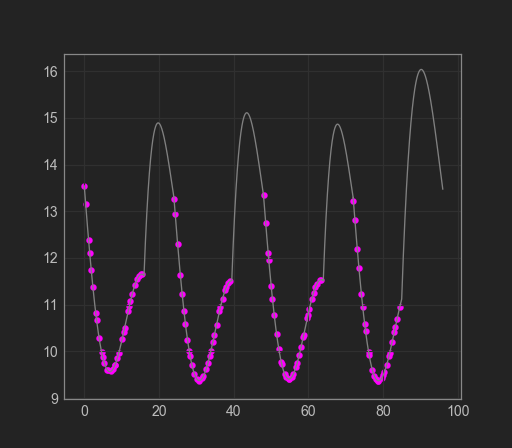

In [5]:
%matplotlib notebook
plt.plot(alertData.time, alertData.levAl, 'gray')
for i in range(alertData.smpAl.time.size):
    plt.scatter(alertData.smpAl.time[i], alertData.smpAl.levAl[i], c = 'fuchsia')

In [6]:
setTime = alertData.smpAl.time
setAl = alertData.smpAl.levAl

In [7]:
k = np.array([])
for i in range(setTime.size):
    if i == 0:
        k = np.asarray(setTime[i])
    else:
        k = np.concatenate((k, np.asarray(setTime[i])), 0)
        
test = np.array(k)
np.diff(test)

array([0.37128, 0.78336, 0.3024 , 0.41472, 0.426  , 0.77088, 0.23904,
       0.65544, 0.69312, 0.26232, 0.45552, 0.78408, 0.09432, 0.94488,
       0.54864, 0.45648, 0.06624, 0.56184, 0.4392 , 0.88968, 0.40992,
       0.2424 , 0.93456, 0.30048, 0.32016, 0.48   , 0.67248, 0.66792,
       0.39048, 0.60216, 0.31752, 8.53944, 0.30312, 0.6696 , 0.71232,
       0.48648, 0.48192, 0.4152 , 0.53184, 0.44904, 0.24576, 0.48   ,
       0.69912, 0.6264 , 0.48432, 0.12792, 0.87072, 0.26808, 0.7512 ,
       0.50376, 0.44208, 0.32112, 0.53448, 0.36696, 0.60936, 0.79128,
       0.26808, 0.54048, 0.69888, 0.28368, 0.5304 , 0.46704, 9.0024 ,
       0.58536, 0.66048, 0.1536 , 0.6492 , 0.3492 , 0.4752 , 0.63912,
       0.59856, 0.63672, 0.15336, 0.7644 , 0.44496, 0.60312, 0.0372 ,
       0.75816, 0.45768, 0.69264, 0.35496, 0.52464, 0.52824, 0.606  ,
       0.10248, 0.95472, 0.16896, 0.37632, 0.64704, 0.47256, 0.49104,
       0.39672, 0.92616, 0.28872, 8.5788 , 0.39432, 0.62616, 0.46392,
       0.6444 , 0.36

In [8]:
modelMOLI = MOLIwhiteBox('trivial')
modelMOLI.fit(setTime, setAl, windowAwake)

This is a MOLI white Box alertness model


In [9]:
modelMOLI.cphase

-4.407392370295771

In [10]:
modelMOLI.sPar

 active_mask: array([0., 0.])
        cost: 2.8682962553981557e-12
         fun: array([ 1.81405255e-06, -2.71710730e-07, -1.54012309e-06])
        grad: array([-1.23162380e-10,  3.54232321e-11])
         jac: array([[ 0.9525424 , -0.28299385],
       [ 0.96077393, -0.24952227],
       [ 0.9525424 , -0.28932964]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 3
        njev: 3
  optimality: 1.2316237991562393e-10
      status: 1
     success: True
           x: array([14.30000379,  2.6247419 ])

<IPython.core.display.Javascript object>


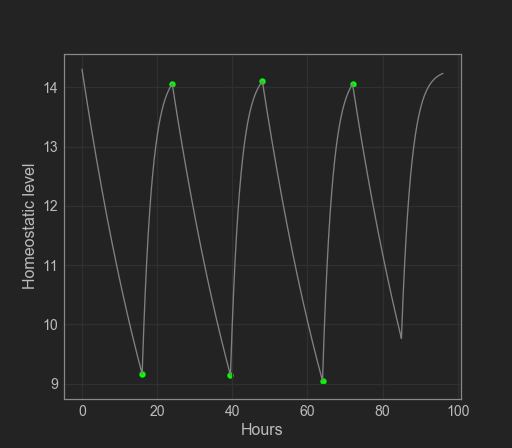

In [11]:
for i in range(alertData.time.shape[1]):
    plt.plot(alertData.time.iloc[:,i].values, alertData.levHom.iloc[:,i].values, 'grey')
    if (i != 0):
        plt.scatter(modelMOLI.hNight.loc[i-1,'t_w'], modelMOLI.hNight.loc[i-1,'h_w'], c = 'lime')
        plt.scatter(modelMOLI.hNight.loc[i-1,'t_s'], modelMOLI.hNight.loc[i-1,'h_s'], c = 'lime')
plt.xlabel('Hours')
plt.ylabel('Homeostatic level')
plt.show()

<IPython.core.display.Javascript object>


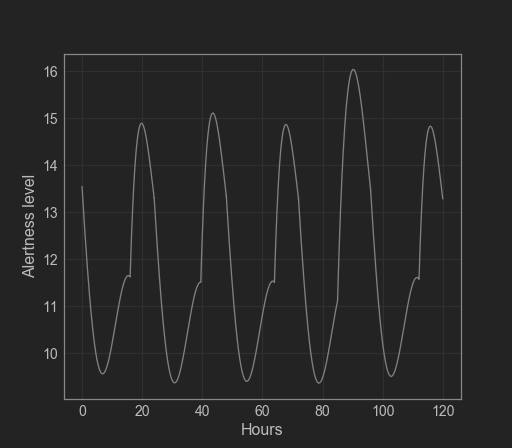

Text(0, 0.5, 'Alertness level')

In [12]:
windowSim = [16, 15.5, 16, 13, 16.1]
alertVal = simAlert(5) #number_days
alertVal.generate(windowSim, 100000) #window_decision, resolution

plt.plot(alertVal.time, alertVal.levAl, 'gray')
plt.xlabel('Hours')
plt.ylabel('Alertness level')

In [13]:
sTime = pd.DataFrame(columns = {'init','final'})
for i in range(alertVal.time.shape[1]):
    sTime.loc[i,'init'] = 24.0*i
    sTime.loc[i,'final'] = 24*i + windowSim[i]
__init = alertVal.levAl.loc[0,0]

In [14]:
dtPred = modelMOLI.predict(sTime, __init)

In [15]:
dtPred.simAl.size

5

<IPython.core.display.Javascript object>


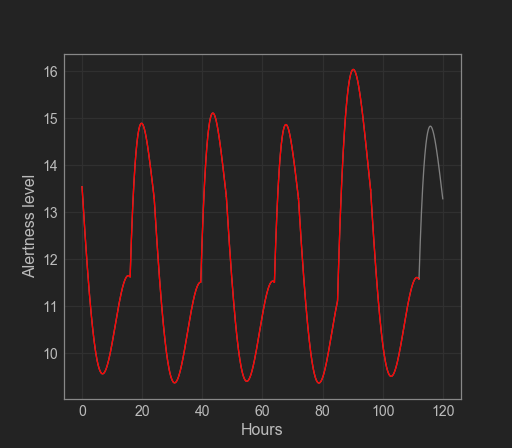

Text(0, 0.5, 'Alertness level')

In [16]:
plt.plot(alertVal.time, alertVal.levAl, 'gray')
for i in range(dtPred.dt.size):
    plt.plot(dtPred.dt.iloc[i], dtPred.simAl.iloc[i], 'red')
plt.xlabel('Hours')
plt.ylabel('Alertness level')